# 🤖 Modelado - Predicción de Conversión

**Objetivo:** Entrenar modelos de clasificación para predecir conversiones en intermediación laboral.

**Modelos a entrenar:**
1. Regresión Logística (Baseline)
2. XGBoost
3. LightGBM

**Métricas de evaluación:** AUC-ROC, Precision, Recall, F1-Score, Matriz de Confusión

## 1. Importar librerías

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
import lightgbm as lgb

# Agregar el directorio src al path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))
from database import get_engine, query_to_dataframe

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Librerías importadas exitosamente")

✅ Librerías importadas exitosamente


## 2. Cargar datos

In [3]:
# Crear engine de conexión
engine = get_engine()

# Query para extraer los datos
query = """
SELECT *
FROM tb_modelo_conversion_intermediacion
"""

# Cargar datos
df = query_to_dataframe(query, engine)

print(f"\n📦 Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"📊 Tasa de conversión: {df['conversion'].mean()*100:.2f}%")

✅ Engine SQLAlchemy creado exitosamente
✅ Query ejecutado exitosamente. Filas: 158331

📦 Dataset cargado: 158,331 filas × 32 columnas
📊 Tasa de conversión: 47.49%


## 3. Preprocesamiento

### 3.1 Tratamiento de valores nulos

In [4]:
print("\n🔍 Valores nulos antes del tratamiento:")
print(df[['duracion_llamada', 'intentos']].isnull().sum())

# duracion_llamada: crear variable dummy + imputar con 0
df['tiene_duracion_llamada'] = df['duracion_llamada'].notna().astype(int)
df['duracion_llamada'] = df['duracion_llamada'].fillna(0)

# intentos: imputar con la mediana
mediana_intentos = df['intentos'].median()
df['intentos'] = df['intentos'].fillna(mediana_intentos)

print("\n✅ Valores nulos después del tratamiento:")
print(df[['duracion_llamada', 'intentos', 'tiene_duracion_llamada']].isnull().sum())


🔍 Valores nulos antes del tratamiento:
duracion_llamada    61146
intentos               14
dtype: int64

✅ Valores nulos después del tratamiento:
duracion_llamada          0
intentos                  0
tiene_duracion_llamada    0
dtype: int64


### 3.2 Selección de features

In [5]:
# Features categóricas (para One-Hot Encoding)
categorical_features = [
    'tipo_de_gestion',
    'rango_vacantes',
    'categoria_cargo',
    'categoria_empresa',
    'categoria_requisito',
    'franja_hora_entrevista',
    'categoria_documentacion'
]

# Features numéricas
numeric_features = [
    'tiene_contacto_empresa',
    'contacto',
    'gestionado',
    'sin_gestion',
    'no_contacto',
    'efectividad',
    'intentos',
    'duracion_llamada',
    'tiene_duracion_llamada'
]

# Variable objetivo
target = 'conversion'

print(f"\n📊 Features seleccionadas:")
print(f"   - Categóricas: {len(categorical_features)}")
print(f"   - Numéricas: {len(numeric_features)}")
print(f"   - Target: {target}")


📊 Features seleccionadas:
   - Categóricas: 7
   - Numéricas: 9
   - Target: conversion


### 3.3 One-Hot Encoding de variables categóricas

In [6]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df[categorical_features + numeric_features], 
                             columns=categorical_features, 
                             drop_first=True)  # Evitar multicolinealidad

print(f"\n✅ Encoding completado:")
print(f"   - Features originales: {len(categorical_features) + len(numeric_features)}")
print(f"   - Features después de encoding: {df_encoded.shape[1]}")

# Agregar la variable objetivo
df_encoded['conversion'] = df[target].values

print(f"\n📦 Dataset final: {df_encoded.shape}")


✅ Encoding completado:
   - Features originales: 16
   - Features después de encoding: 59

📦 Dataset final: (158331, 60)


## 4. Split Train/Test

In [7]:
# Separar features y target
X = df_encoded.drop('conversion', axis=1)
y = df_encoded['conversion']

# Split 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n📊 Split completado:")
print(f"   - Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Test:  {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n   - Conversión en Train: {y_train.mean()*100:.2f}%")
print(f"   - Conversión en Test:  {y_test.mean()*100:.2f}%")


📊 Split completado:
   - Train: 126,664 registros (80.0%)
   - Test:  31,667 registros (20.0%)

   - Conversión en Train: 47.49%
   - Conversión en Test:  47.48%


## 5. Entrenamiento de modelos

### 5.1 Modelo 1: Regresión Logística (Baseline)

In [8]:
print("\n" + "="*70)
print("🔹 MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)")
print("="*70)

# Entrenar modelo
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Métricas
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\n📊 AUC-ROC: {auc_lr:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Conversión', 'Conversión']))


🔹 MODELO 1: REGRESIÓN LOGÍSTICA (BASELINE)

📊 AUC-ROC: 0.9946

📋 Classification Report:
               precision    recall  f1-score   support

No Conversión       1.00      0.97      0.98     16630
   Conversión       0.97      1.00      0.98     15037

     accuracy                           0.98     31667
    macro avg       0.98      0.98      0.98     31667
 weighted avg       0.98      0.98      0.98     31667



### 5.2 Modelo 2: XGBoost

In [9]:
print("\n" + "="*70)
print("🔹 MODELO 2: XGBOOST")
print("="*70)

# Parámetros optimizados para XGBoost
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

# Entrenar modelo
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Métricas
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\n📊 AUC-ROC: {auc_xgb:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Conversión', 'Conversión']))


🔹 MODELO 2: XGBOOST

📊 AUC-ROC: 0.9974

📋 Classification Report:
               precision    recall  f1-score   support

No Conversión       1.00      0.97      0.99     16630
   Conversión       0.97      1.00      0.98     15037

     accuracy                           0.98     31667
    macro avg       0.98      0.99      0.98     31667
 weighted avg       0.99      0.98      0.98     31667



### 5.3 Modelo 3: LightGBM

In [10]:
print("\n" + "="*70)
print("🔹 MODELO 3: LIGHTGBM")
print("="*70)

# Parámetros optimizados para LightGBM
lgb_params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'objective': 'binary',
    'metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Entrenar modelo
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

# Predicciones
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Métricas
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

print(f"\n📊 AUC-ROC: {auc_lgb:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=['No Conversión', 'Conversión']))


🔹 MODELO 3: LIGHTGBM

📊 AUC-ROC: 0.9973

📋 Classification Report:
               precision    recall  f1-score   support

No Conversión       1.00      0.97      0.99     16630
   Conversión       0.97      1.00      0.98     15037

     accuracy                           0.98     31667
    macro avg       0.98      0.99      0.98     31667
 weighted avg       0.99      0.98      0.98     31667



## 6. Comparación de modelos


📊 COMPARACIÓN DE MODELOS


,Modelo,AUC-ROC
1,XGBoost,0.9974
2,LightGBM,0.9973
0,Regresión Logística,0.9946


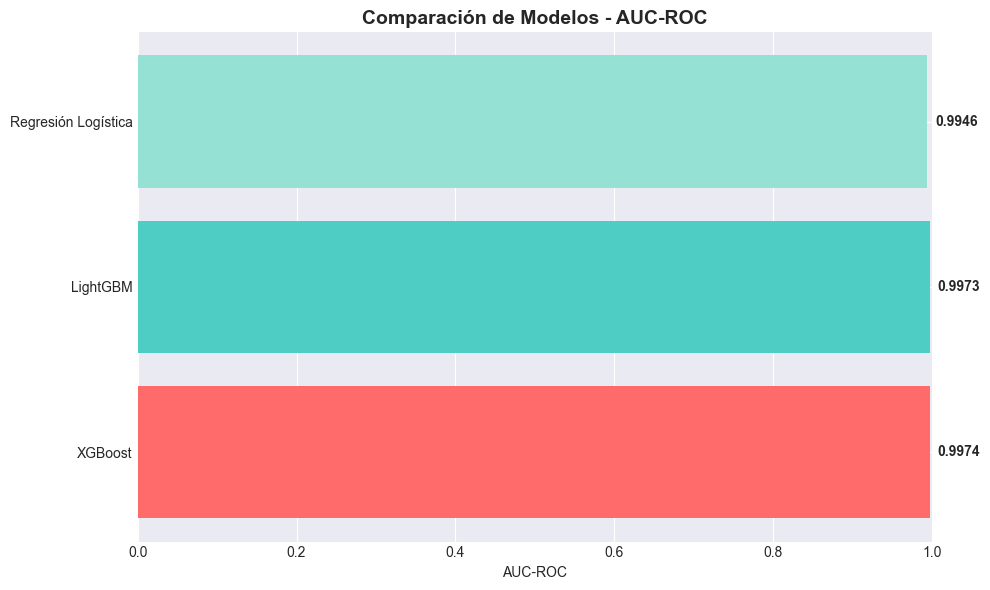


🏆 Mejor modelo: XGBoost (AUC-ROC: 0.9974)


In [11]:
# Resumen de AUC-ROC
resultados = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'XGBoost', 'LightGBM'],
    'AUC-ROC': [auc_lr, auc_xgb, auc_lgb]
}).sort_values('AUC-ROC', ascending=False)

print("\n" + "="*70)
print("📊 COMPARACIÓN DE MODELOS")
print("="*70)
display(resultados)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(resultados['Modelo'], resultados['AUC-ROC'], color=['#ff6b6b', '#4ecdc4', '#95e1d3'])
plt.xlabel('AUC-ROC')
plt.title('Comparación de Modelos - AUC-ROC', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
for i, v in enumerate(resultados['AUC-ROC'].values):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar el mejor modelo
mejor_modelo = resultados.iloc[0]['Modelo']
mejor_auc = resultados.iloc[0]['AUC-ROC']
print(f"\n🏆 Mejor modelo: {mejor_modelo} (AUC-ROC: {mejor_auc:.4f})")

## 7. Curvas ROC

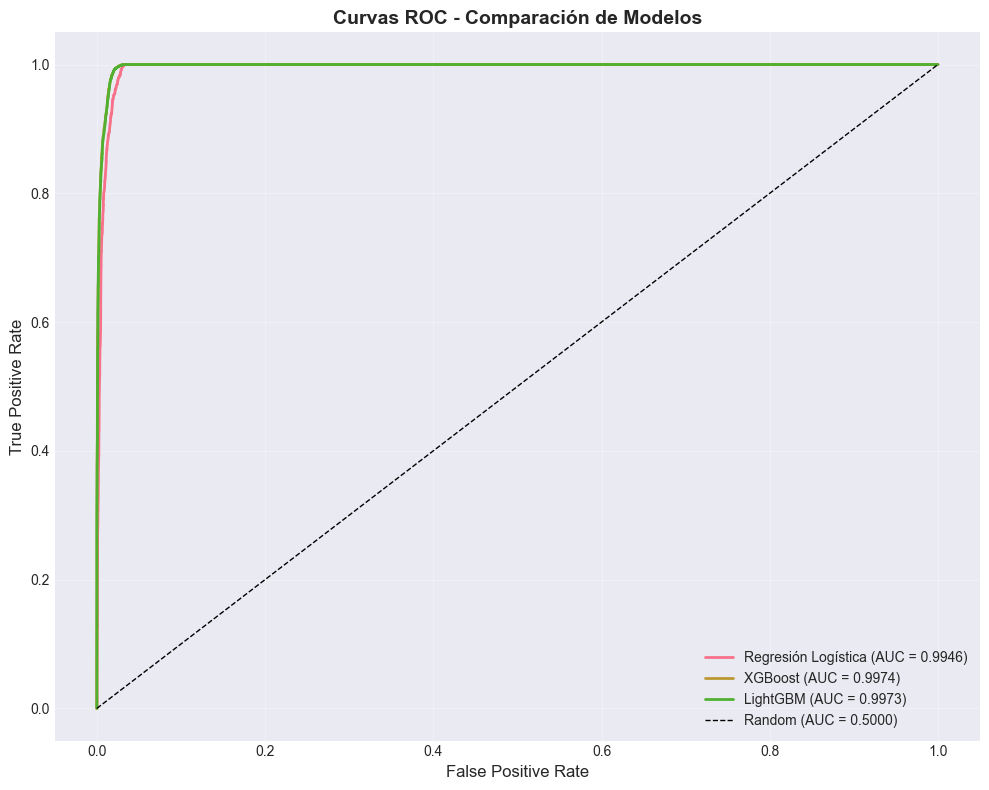

In [12]:
# Calcular curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

# Visualización
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Regresión Logística (AUC = {auc_lr:.4f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Matriz de confusión del mejor modelo

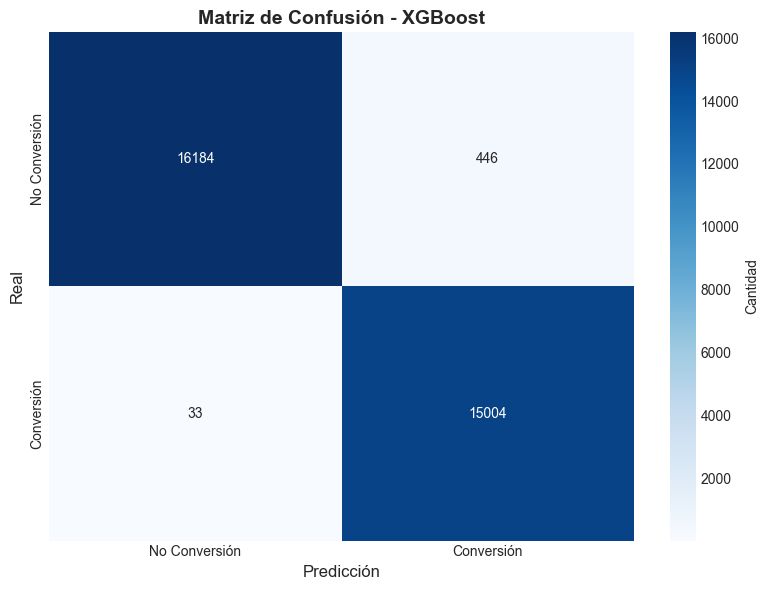


📊 Métricas de la matriz de confusión:
   - True Negatives:  16,184
   - False Positives: 446
   - False Negatives: 33
   - True Positives:  15,004

   - Accuracy: 0.9849
   - Precision: 0.9711
   - Recall: 0.9978
   - F1-Score: 0.9843


In [13]:
# Seleccionar predicciones del mejor modelo
if mejor_modelo == 'XGBoost':
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
elif mejor_modelo == 'LightGBM':
    y_pred_best = y_pred_lgb
    y_pred_proba_best = y_pred_proba_lgb
else:
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Conversión', 'Conversión'],
            yticklabels=['No Conversión', 'Conversión'],
            cbar_kws={'label': 'Cantidad'})
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title(f'Matriz de Confusión - {mejor_modelo}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Cálculos adicionales
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Métricas de la matriz de confusión:")
print(f"   - True Negatives:  {tn:,}")
print(f"   - False Positives: {fp:,}")
print(f"   - False Negatives: {fn:,}")
print(f"   - True Positives:  {tp:,}")
print(f"\n   - Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"   - Precision: {tp / (tp + fp):.4f}")
print(f"   - Recall: {tp / (tp + fn):.4f}")
print(f"   - F1-Score: {2 * (tp / (tp + fp)) * (tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn))):.4f}")

## 9. Feature Importance (Mejor modelo)


📊 Top 20 Features más importantes (XGBoost):


,Feature,Importance
1,contacto,0.4541
5,efectividad,0.3998
4,no_contacto,0.1262
8,tiene_duracion_llamada,0.0027
6,intentos,0.0011
40,categoria_empresa_seguridad,0.0009
55,categoria_documentacion_completa,0.0007
7,duracion_llamada,0.0005
16,rango_vacantes_300+,0.0005
14,rango_vacantes_100-200,0.0005


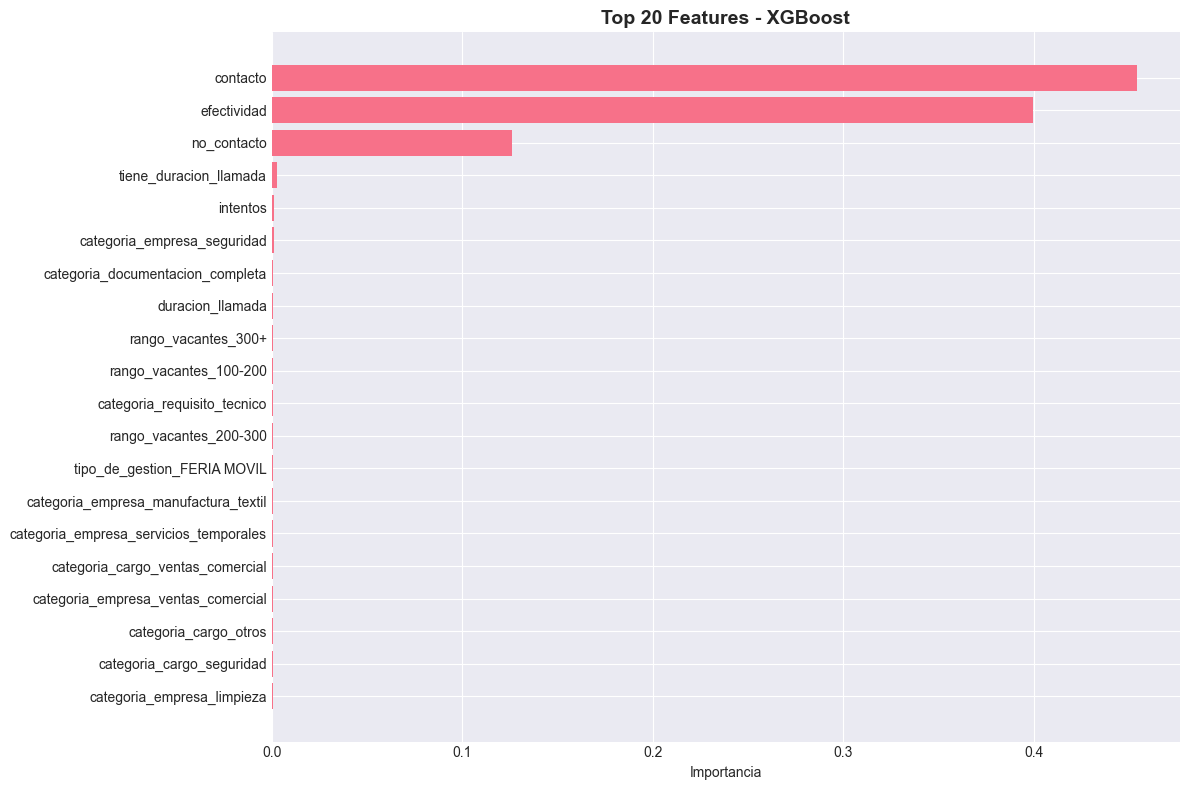

In [14]:
# Obtener feature importance según el modelo
if mejor_modelo == 'XGBoost':
    feature_importance = xgb_model.feature_importances_
elif mejor_modelo == 'LightGBM':
    feature_importance = lgb_model.feature_importances_
else:
    feature_importance = np.abs(lr_model.coef_[0])

# Crear DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(20)

print(f"\n📊 Top 20 Features más importantes ({mejor_modelo}):")
display(importance_df)

# Visualización
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Importancia')
plt.title(f'Top 20 Features - {mejor_modelo}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Crear Score de 3 niveles


📊 Distribución de Scores:
Score
Alto     16217
Bajo     15104
Medio      346
Name: count, dtype: int64

   Total: 31,667

📈 Tasa de conversión real por Score:


,Conversiones,Total,Tasa,Tasa_%
Score,,,,
Alto,33,16217,0.0020,0.2035
Bajo,14801,15104,0.9799,97.9939
Medio,203,346,0.5867,58.6705


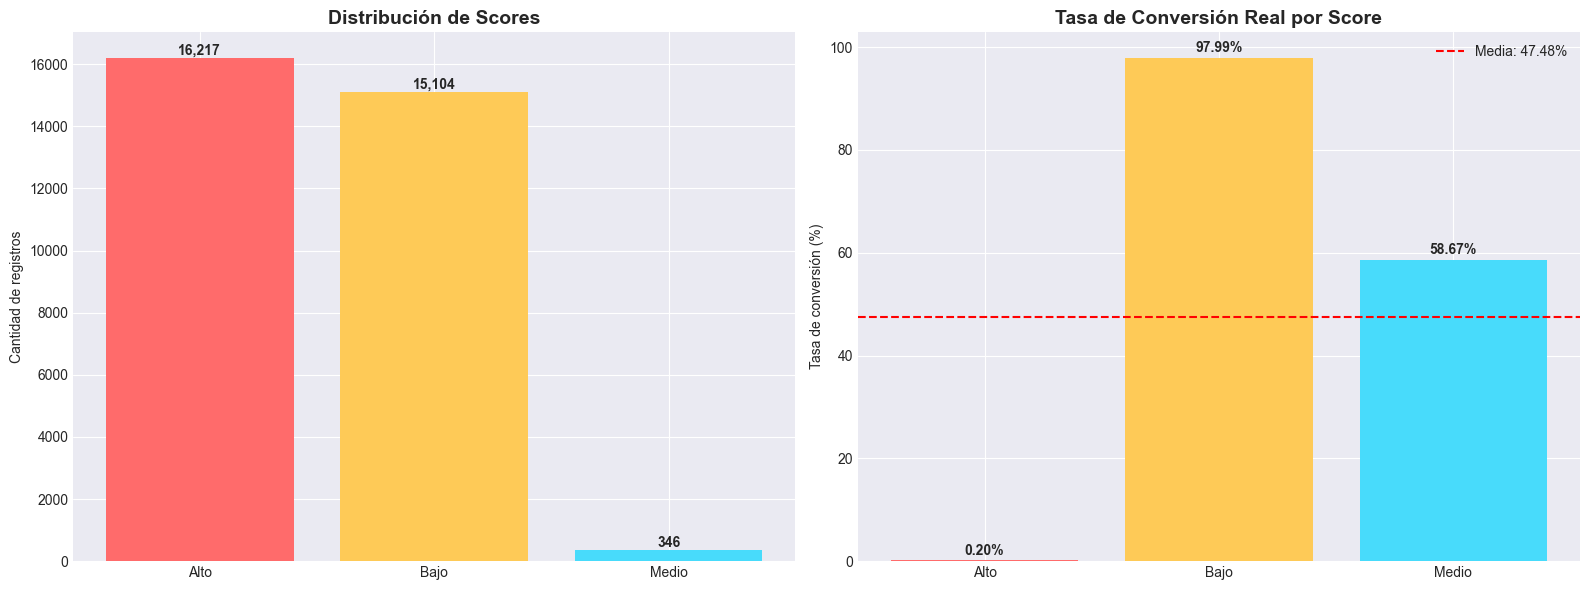

In [15]:
# Crear scoring de 3 niveles basado en probabilidad de conversión
def asignar_score(probabilidad):
    """
    Asigna un score categórico basado en la probabilidad de conversión
    
    - Alto: 0-50% probabilidad (BAJA probabilidad de conversión)
    - Medio: 50-75% probabilidad
    - Bajo: 75-100% probabilidad (ALTA probabilidad de conversión)
    """
    if probabilidad < 0.50:
        return 'Alto'
    elif probabilidad < 0.75:
        return 'Medio'
    else:
        return 'Bajo'

# Aplicar scoring
scores = [asignar_score(p) for p in y_pred_proba_best]

# Análisis de distribución de scores
scores_df = pd.DataFrame({
    'Score': scores,
    'Probabilidad': y_pred_proba_best,
    'Real': y_test.values
})

print("\n📊 Distribución de Scores:")
score_dist = scores_df['Score'].value_counts().sort_index()
print(score_dist)
print(f"\n   Total: {len(scores_df):,}")

# Tasa de conversión por score
print("\n📈 Tasa de conversión real por Score:")
conversion_by_score = scores_df.groupby('Score')['Real'].agg(['sum', 'count', 'mean'])
conversion_by_score.columns = ['Conversiones', 'Total', 'Tasa']
conversion_by_score['Tasa_%'] = conversion_by_score['Tasa'] * 100
display(conversion_by_score)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribución de scores
axes[0].bar(score_dist.index, score_dist.values, color=['#ff6b6b', '#feca57', '#48dbfb'])
axes[0].set_title('Distribución de Scores', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad de registros')
for i, v in enumerate(score_dist.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Tasa de conversión por score
axes[1].bar(conversion_by_score.index, conversion_by_score['Tasa_%'], color=['#ff6b6b', '#feca57', '#48dbfb'])
axes[1].set_title('Tasa de Conversión Real por Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Tasa de conversión (%)')
axes[1].axhline(y=y_test.mean() * 100, color='red', linestyle='--', label=f'Media: {y_test.mean()*100:.2f}%')
axes[1].legend()
for i, v in enumerate(conversion_by_score['Tasa_%'].values):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Guardar el mejor modelo

In [ ]:
# Seleccionar el mejor modelo para guardar
if mejor_modelo == 'XGBoost':
    modelo_final = xgb_model
elif mejor_modelo == 'LightGBM':
    modelo_final = lgb_model
else:
    modelo_final = lr_model

# Guardar modelo
model_path = os.path.join('..', 'models', 'modelo_conversion.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(modelo_final, f)

print(f"\n💾 Modelo guardado en: {model_path}")

# Guardar también las columnas del modelo (para predicciones futuras)
columns_path = os.path.join('..', 'models', 'model_columns.pkl')
with open(columns_path, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print(f"💾 Columnas del modelo guardadas en: {columns_path}")

## 12. Resumen final

In [ ]:
print("\n" + "="*70)
print("🎯 RESUMEN FINAL DEL MODELADO")
print("="*70)

print(f"\n1️⃣ Dataset:")
print(f"   - Total de registros: {len(df):,}")
print(f"   - Train: {len(X_train):,} | Test: {len(X_test):,}")
print(f"   - Features: {X_train.shape[1]}")

print(f"\n2️⃣ Mejor modelo: {mejor_modelo}")
print(f"   - AUC-ROC: {mejor_auc:.4f}")

print(f"\n3️⃣ Scoring de 3 niveles:")
for score in ['Alto', 'Medio', 'Bajo']:
    if score in conversion_by_score.index:
        tasa = conversion_by_score.loc[score, 'Tasa_%']
        total = conversion_by_score.loc[score, 'Total']
        print(f"   - {score}: {tasa:.2f}% conversión ({int(total):,} registros)")

print(f"\n4️⃣ Archivos generados:")
print(f"   - Modelo: {model_path}")
print(f"   - Columnas: {columns_path}")

print("\n" + "="*70)
print("✅ MODELADO COMPLETADO EXITOSAMENTE")
print("="*70)

print(f"\n📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

---

## ✅ Próximos pasos:

1. **Script de predicción diaria**: Cargar el modelo y generar predicciones sobre nuevos datos
2. **Automatización**: Crear batch script para ejecución automática
3. **Monitoreo**: Tracking del performance del modelo en producción
4. **Reentrenamiento**: Proceso para actualizar el modelo con nuevos datos